In [ ]:
import os
import sys

# Add the directory containing helper.py to the Python path
# sys.path.append(os.path.abspath("/home/jack/Documents/PhD-research/XAI"))
os.chdir(os.path.abspath("./XAI"))
# Explicitly import the required functions from helper
from helper import *

# Other imports
import torch
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
import torch.distributions as dist
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F

from vae_model import *

In [ ]:
# SECTION: Import other necessary modules


# Load the MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

trainset = MNIST(
    root="~/Documents//data", train=True, download=True, transform=transform
)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = MNIST(
    root="~/Documents//data", train=False, download=True, transform=transform
)
testloader = DataLoader(testset, batch_size=1000, shuffle=True)


# %%
# SECTION: load MNIST dataa only 8


# Create the dataset for digit 8
testset_8 = MNIST_8(testset)
testloader_8 = DataLoader(testset_8, batch_size=32, shuffle=True)


# Create the dataset for digit 9
testset_9 = MNIST_9(testset)
testloader_9 = DataLoader(testset_9, batch_size=32, shuffle=True)

Accuracy of the model on the test images: 99.25%
ID: 1, True y = 8, probability: 1.00000


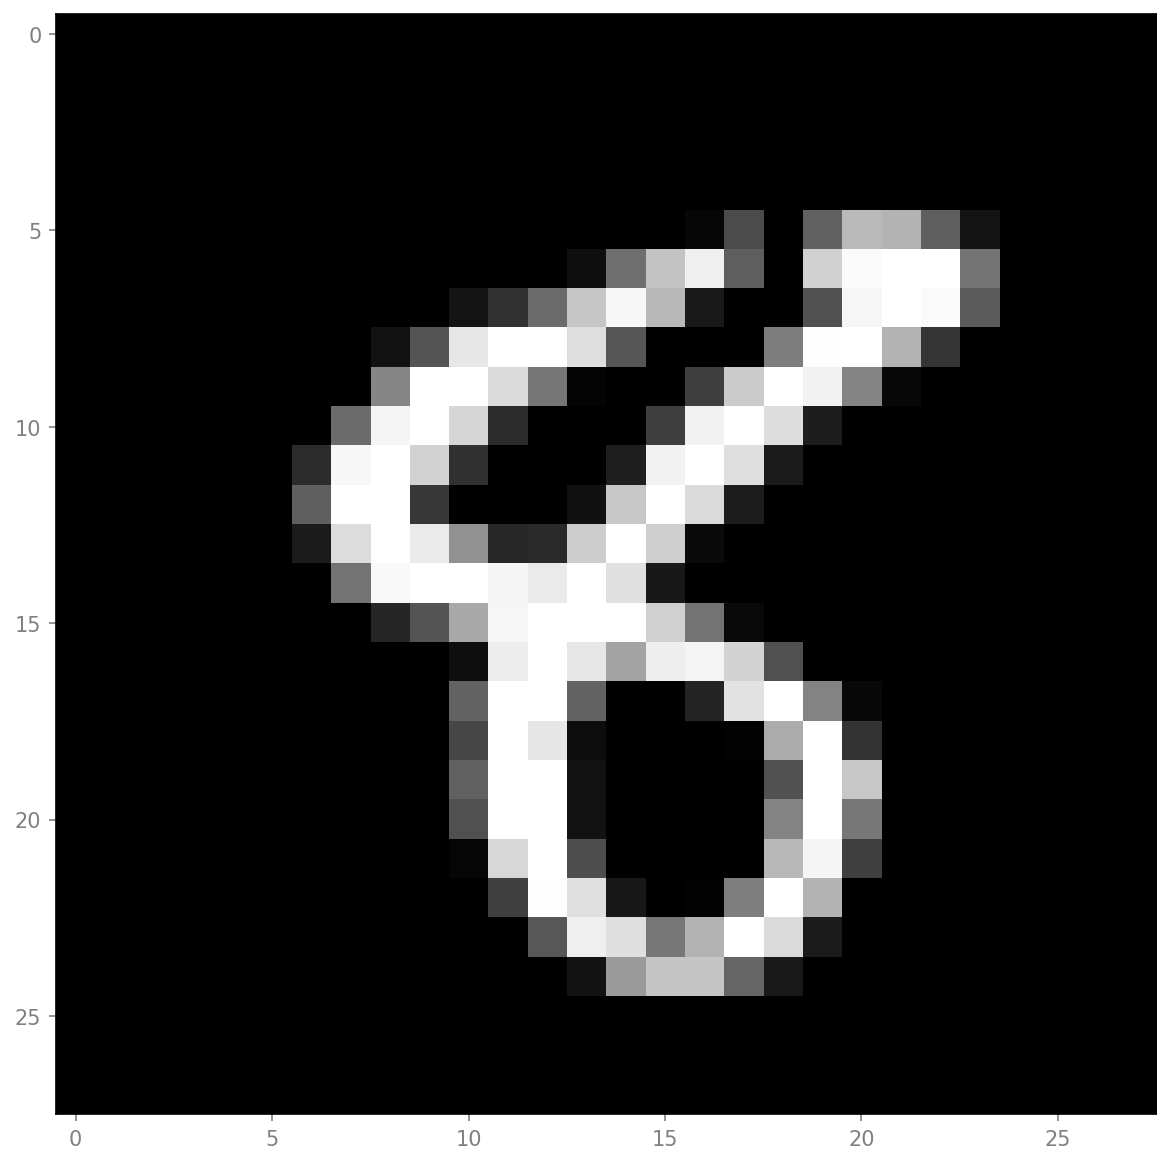

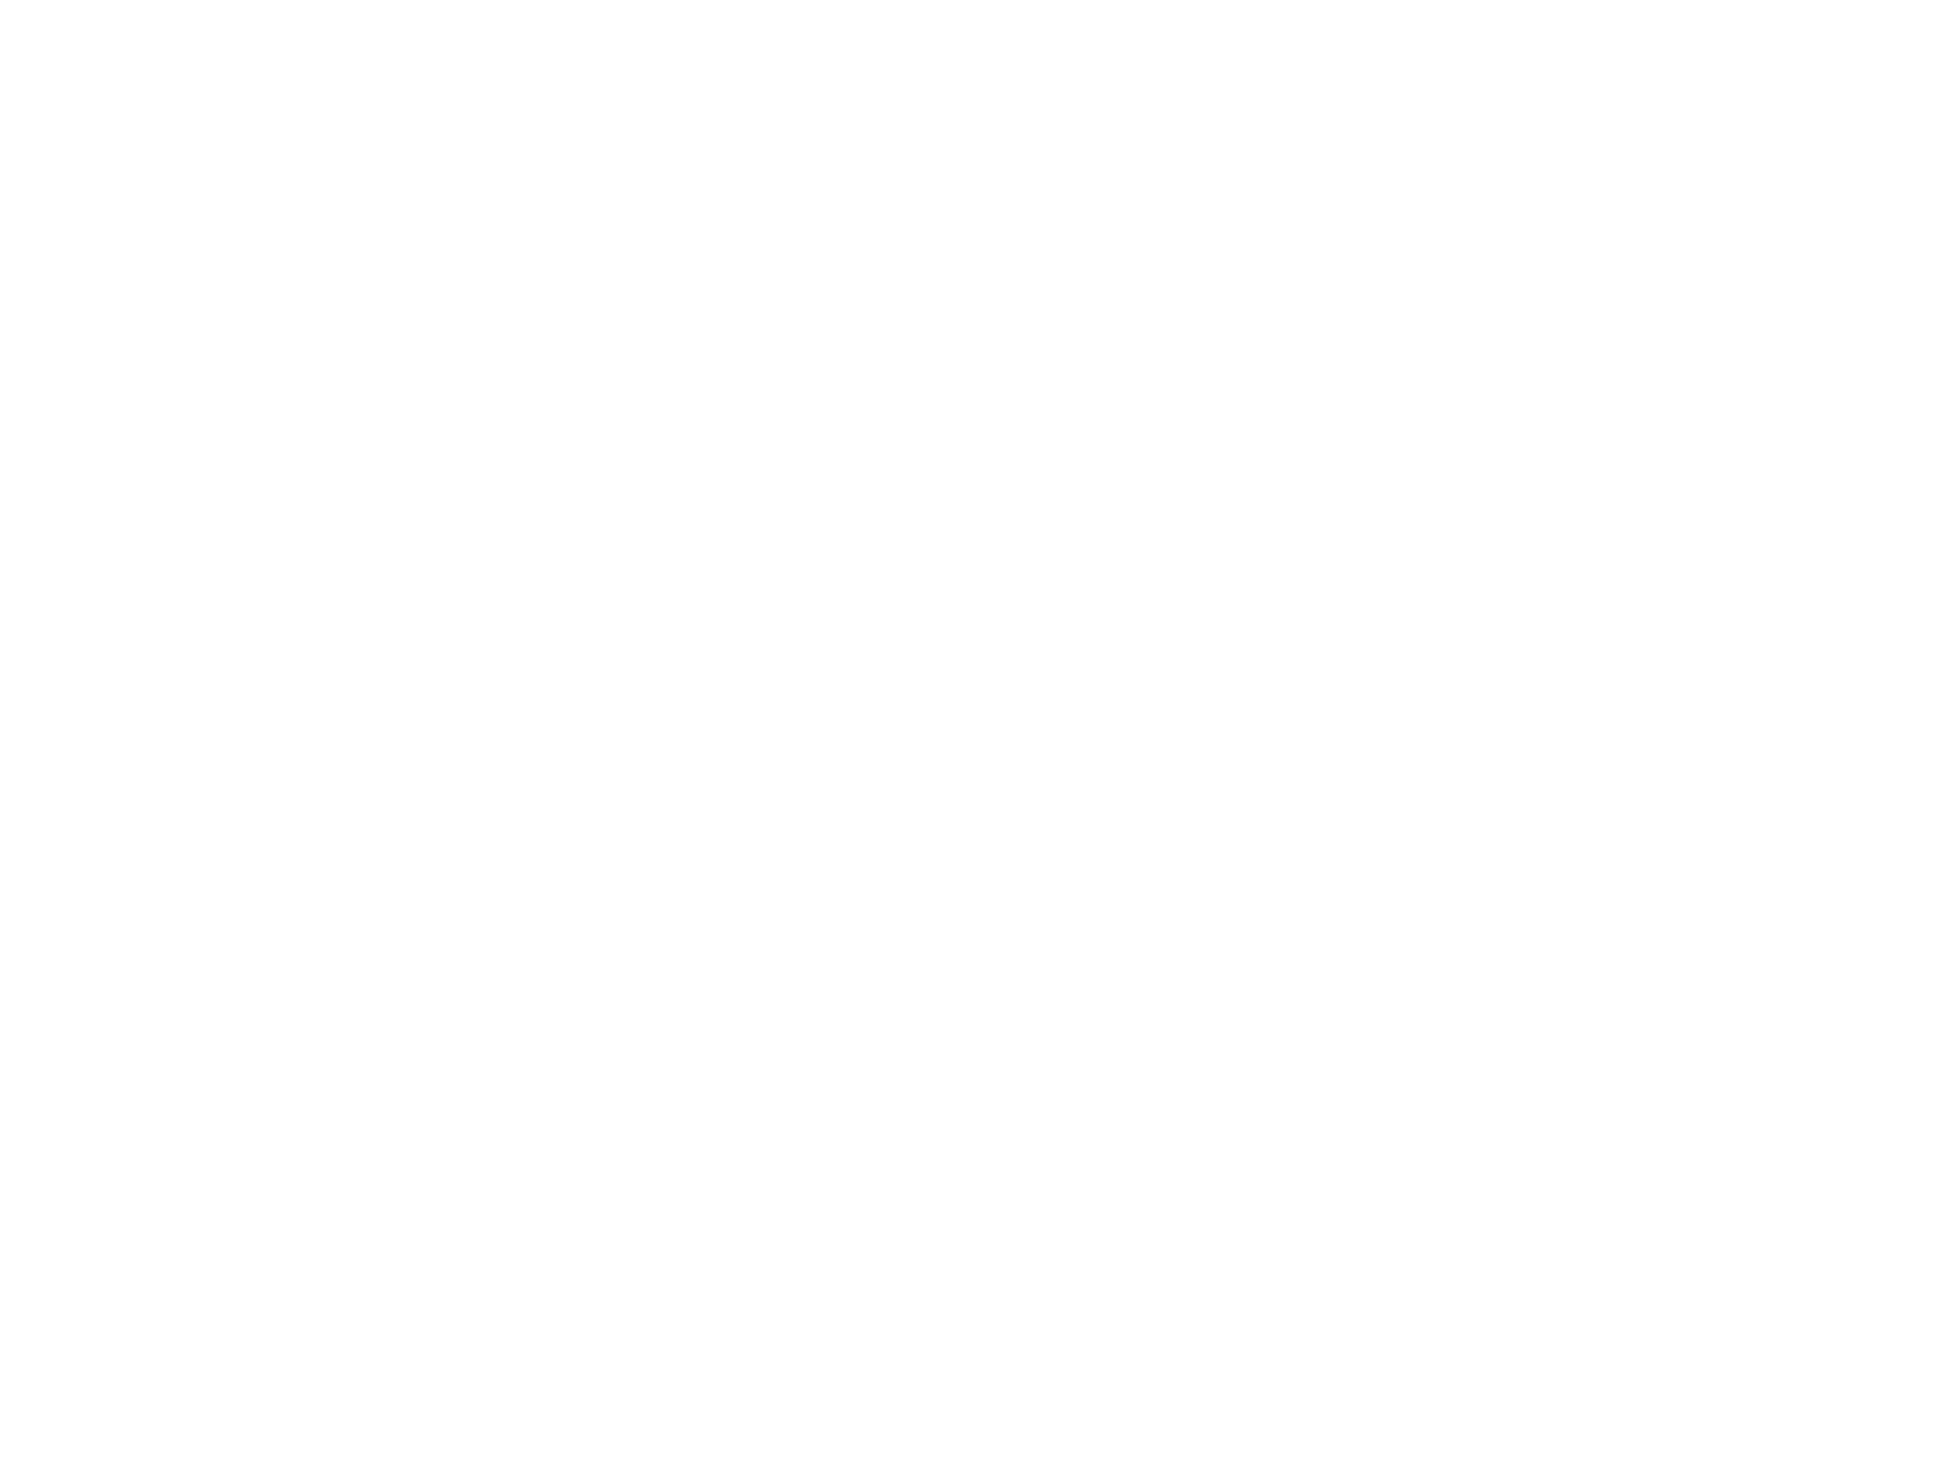

In [1]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
"""## Load CNN Weights"""

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# save the mode weights in .pth format (99.25% accuracy
# torch.save(model.state_dict(), 'CNN_MNSIT.pth')

# NOTE: load the model weights


model.load_state_dict(torch.load("./CNN_MNSIT.pth", weights_only=True))
# Set the model to evaluation mode
model.eval()

# Initialize variables to track the number of correct predictions and the total number of samples
correct = 0
total = 0

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data, target in testloader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

# Calculate and print the accuracy
accuracy = 100 * correct / total
print(f"Accuracy of the model on the test images: {accuracy:.2f}%")

# %%
"""## Inital image setup"""

img_id = 1
input = testset_8[img_id]
true_y = input[1]

img = input[0].squeeze(0).clone().to(device)
predicted = model(img.unsqueeze(0).unsqueeze(0)).argmax().item()
prob = F.softmax(model(img.unsqueeze(0).unsqueeze(0)), dim=1)[0][predicted].item()

img_cpu = img.cpu().numpy()
plt.imshow(img_cpu, cmap="gray")
plt.savefig(f"ID {img_id}-Digit {input[1]} original_image.png")
print(f"ID: {img_id}, True y = {input[1]}, probability: {prob:.5f}")
plt.show()
plt.clf()

In [2]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(in_dim, in_dim)
        self.key = nn.Linear(in_dim, in_dim)
        self.value = nn.Linear(in_dim, in_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        attention = self.softmax(torch.bmm(query.unsqueeze(2), key.unsqueeze(1)))
        out = torch.bmm(attention, value.unsqueeze(2)).squeeze(2)
        return out


class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.attention_mu = SelfAttention(128)
        self.attention_logvar = SelfAttention(128)
        self.fc_mu = nn.Linear(128, 20)
        self.fc_logvar = nn.Linear(128, 20)

        # Decoder
        self.fc2 = nn.Linear(20, 128)
        self.fc3 = nn.Linear(128, 64 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(
            64, 32, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.deconv2 = nn.ConvTranspose2d(
            32, 1, kernel_size=3, stride=2, padding=1, output_padding=1
        )

    def encode(self, x):
        h1 = F.relu(self.conv1(x))
        h2 = F.relu(self.conv2(h1))
        h2 = h2.view(-1, 64 * 7 * 7)
        h3 = F.relu(self.fc1(h2))
        h3_mu = self.attention_mu(h3)
        h3_logvar = self.attention_logvar(h3)
        return self.fc_mu(h3_mu), self.fc_logvar(h3_logvar)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h4 = F.relu(self.fc2(z))
        h5 = F.relu(self.fc3(h4))
        h5 = h5.view(-1, 64, 7, 7)
        h6 = F.relu(self.deconv1(h5))
        return torch.sigmoid(self.deconv2(h6))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# Example usage
# Check for MPS support
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE = ConvVAE().to(device)

# Create a dummy input tensor with the same shape as your MNIST data
dummy_input = torch.randn(1, 1, 28, 28).to(device)
output, mu, logvar = VAE(dummy_input)
print(
    f"Output shape: {output.shape}, mu shape: {mu.shape}, logvar shape: {logvar.shape}"
)

Output shape: torch.Size([1, 1, 28, 28]), mu shape: torch.Size([1, 20]), logvar shape: torch.Size([1, 20])


In [3]:
def loss_function(recon_x, x, mu, logvar):

    # print(f"recon_x shape: {recon_x.shape}, x shape: {x.shape}")
    # BCE = F.binary_cross_entropy(recon_x, x, reduction="sum")
    BCE = F.mse_loss(recon_x, x, reduction="sum")
    # print(f"BCE: {BCE.item()}")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # print(f"KLD: {KLD.item()}")
    return BCE + KLD


# Initialize the model, optimizer, and device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "mps"
VAE = ConvVAE().to(device)
optimizer = torch.optim.Adam(VAE.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    VAE.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = VAE(data)
        loss = loss_function(recon_x, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(trainloader.dataset)} ({100. * batch_idx / len(trainloader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}"
            )

    print(
        f"====> Epoch: {epoch} Average loss: {train_loss / len(trainloader.dataset):.4f}"
    )

Train Epoch: 0 [0/60000 (0%)]	Loss: 959.522461
Train Epoch: 0 [6400/60000 (11%)]	Loss: 632.837830
Train Epoch: 0 [12800/60000 (21%)]	Loss: 579.587524
Train Epoch: 0 [19200/60000 (32%)]	Loss: 548.255249
Train Epoch: 0 [25600/60000 (43%)]	Loss: 501.269318
Train Epoch: 0 [32000/60000 (53%)]	Loss: 486.207092
Train Epoch: 0 [38400/60000 (64%)]	Loss: 474.004364
Train Epoch: 0 [44800/60000 (75%)]	Loss: 462.013123
Train Epoch: 0 [51200/60000 (85%)]	Loss: 469.385925
Train Epoch: 0 [57600/60000 (96%)]	Loss: 471.349091
====> Epoch: 0 Average loss: 516.9377
Train Epoch: 1 [0/60000 (0%)]	Loss: 441.185181
Train Epoch: 1 [6400/60000 (11%)]	Loss: 452.031677
Train Epoch: 1 [12800/60000 (21%)]	Loss: 449.813110
Train Epoch: 1 [19200/60000 (32%)]	Loss: 450.078888
Train Epoch: 1 [25600/60000 (43%)]	Loss: 434.749847
Train Epoch: 1 [32000/60000 (53%)]	Loss: 448.507721
Train Epoch: 1 [38400/60000 (64%)]	Loss: 438.362366
Train Epoch: 1 [44800/60000 (75%)]	Loss: 444.589996
Train Epoch: 1 [51200/60000 (85%)]	Los

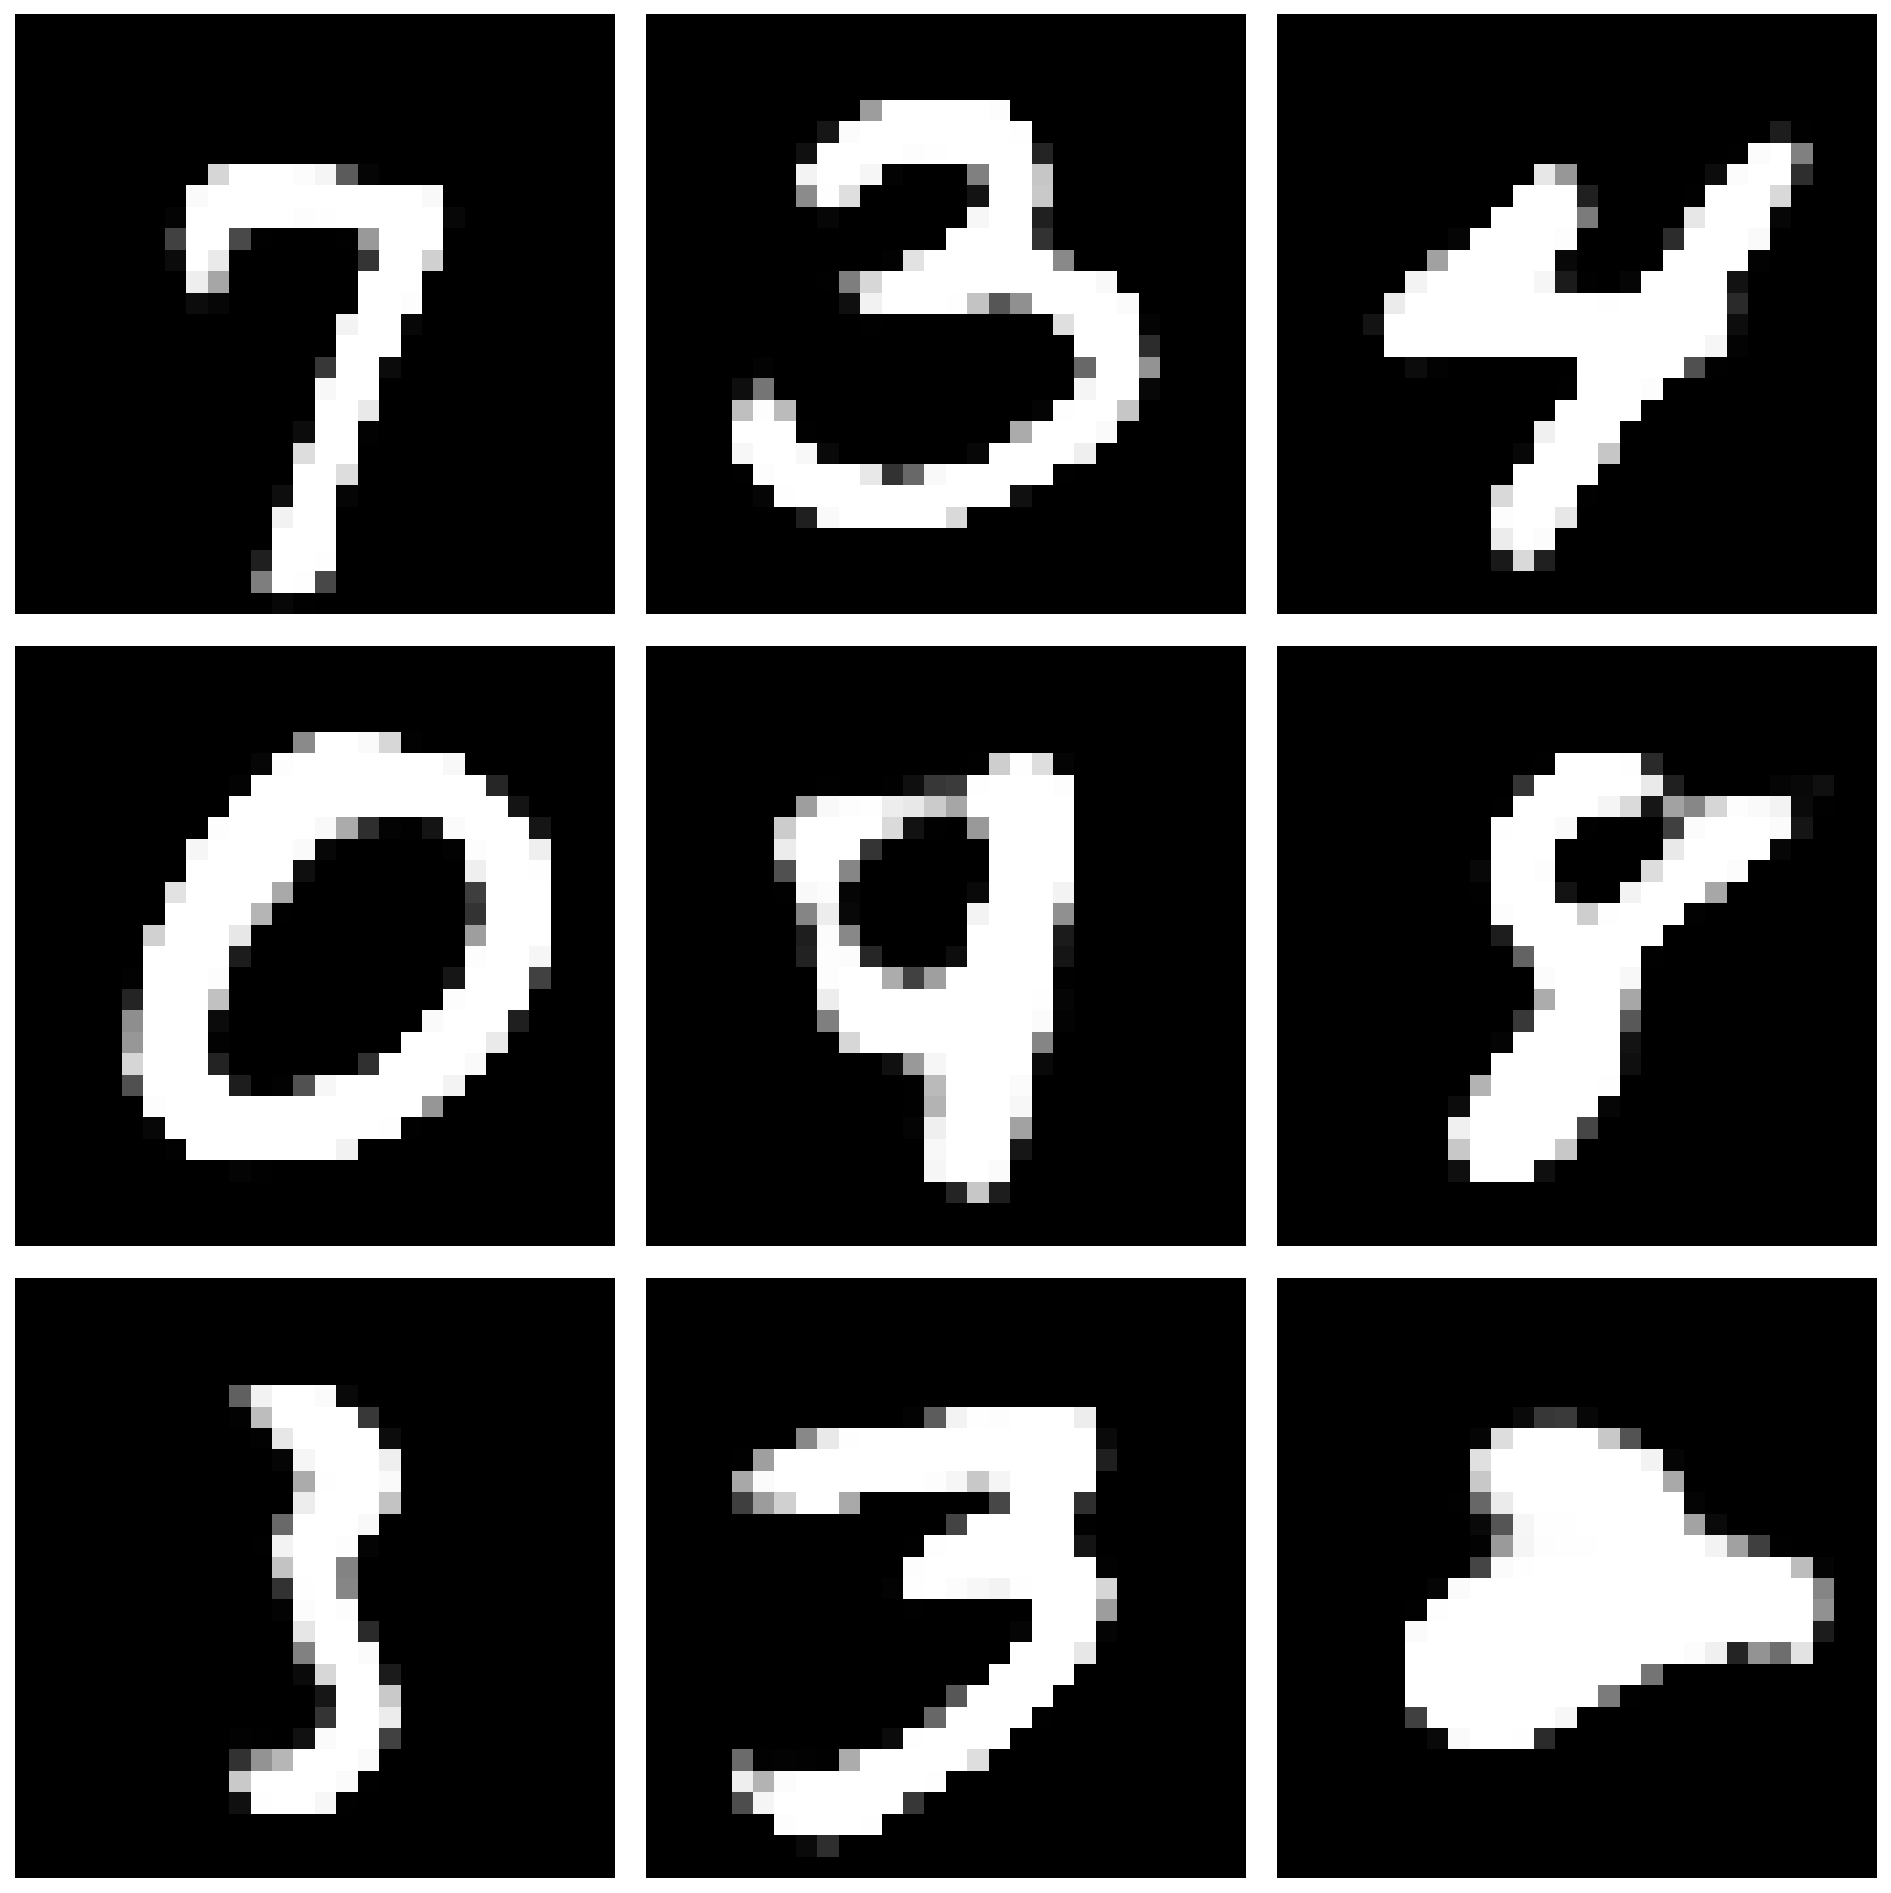

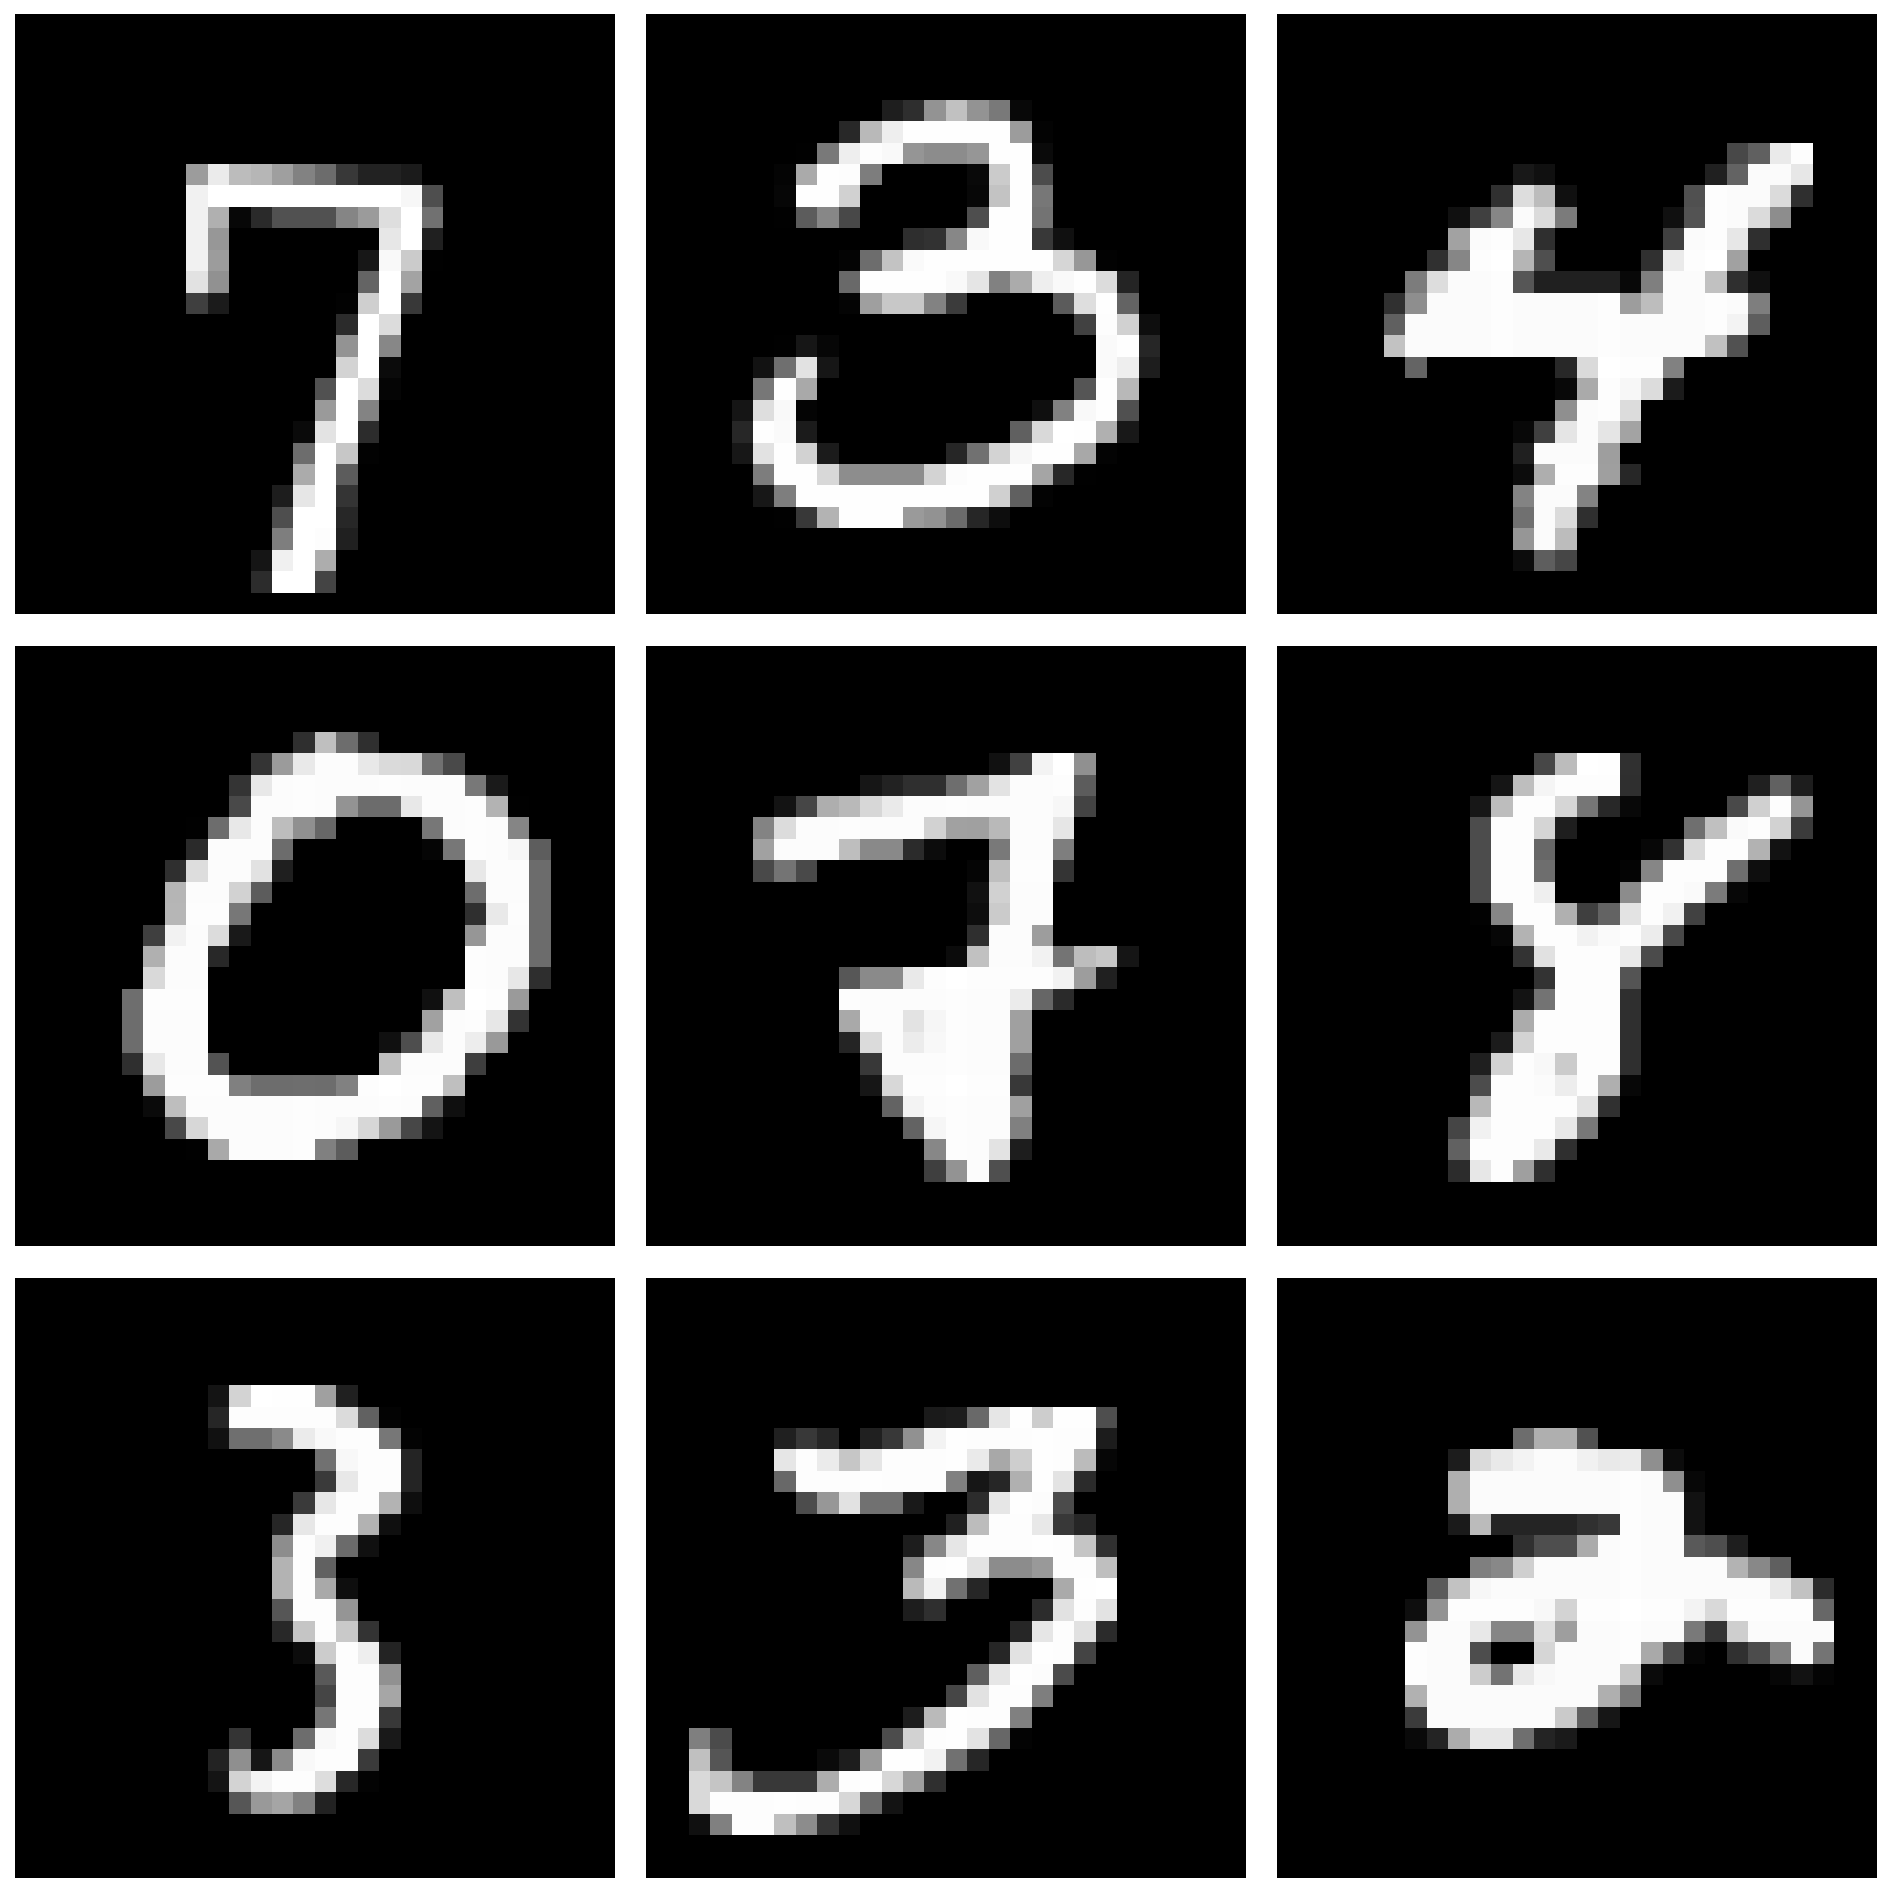

In [4]:
def plot_reconstructions(recon_x):
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    for i, ax in enumerate(axes.flat):
        ax.imshow(recon_x[i], cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    plt.show()


recon_x = recon_x.cpu().detach().numpy()
recon_x = recon_x.reshape(-1, 28, 28)
# Assuming recon_x is a list or array of reconstructed images
# recon_x = generate_reconstructions()  # Your function to generate recon_x
plot_reconstructions(recon_x)

plot_reconstructions(data.reshape(-1, 28, 28).cpu().detach().numpy())

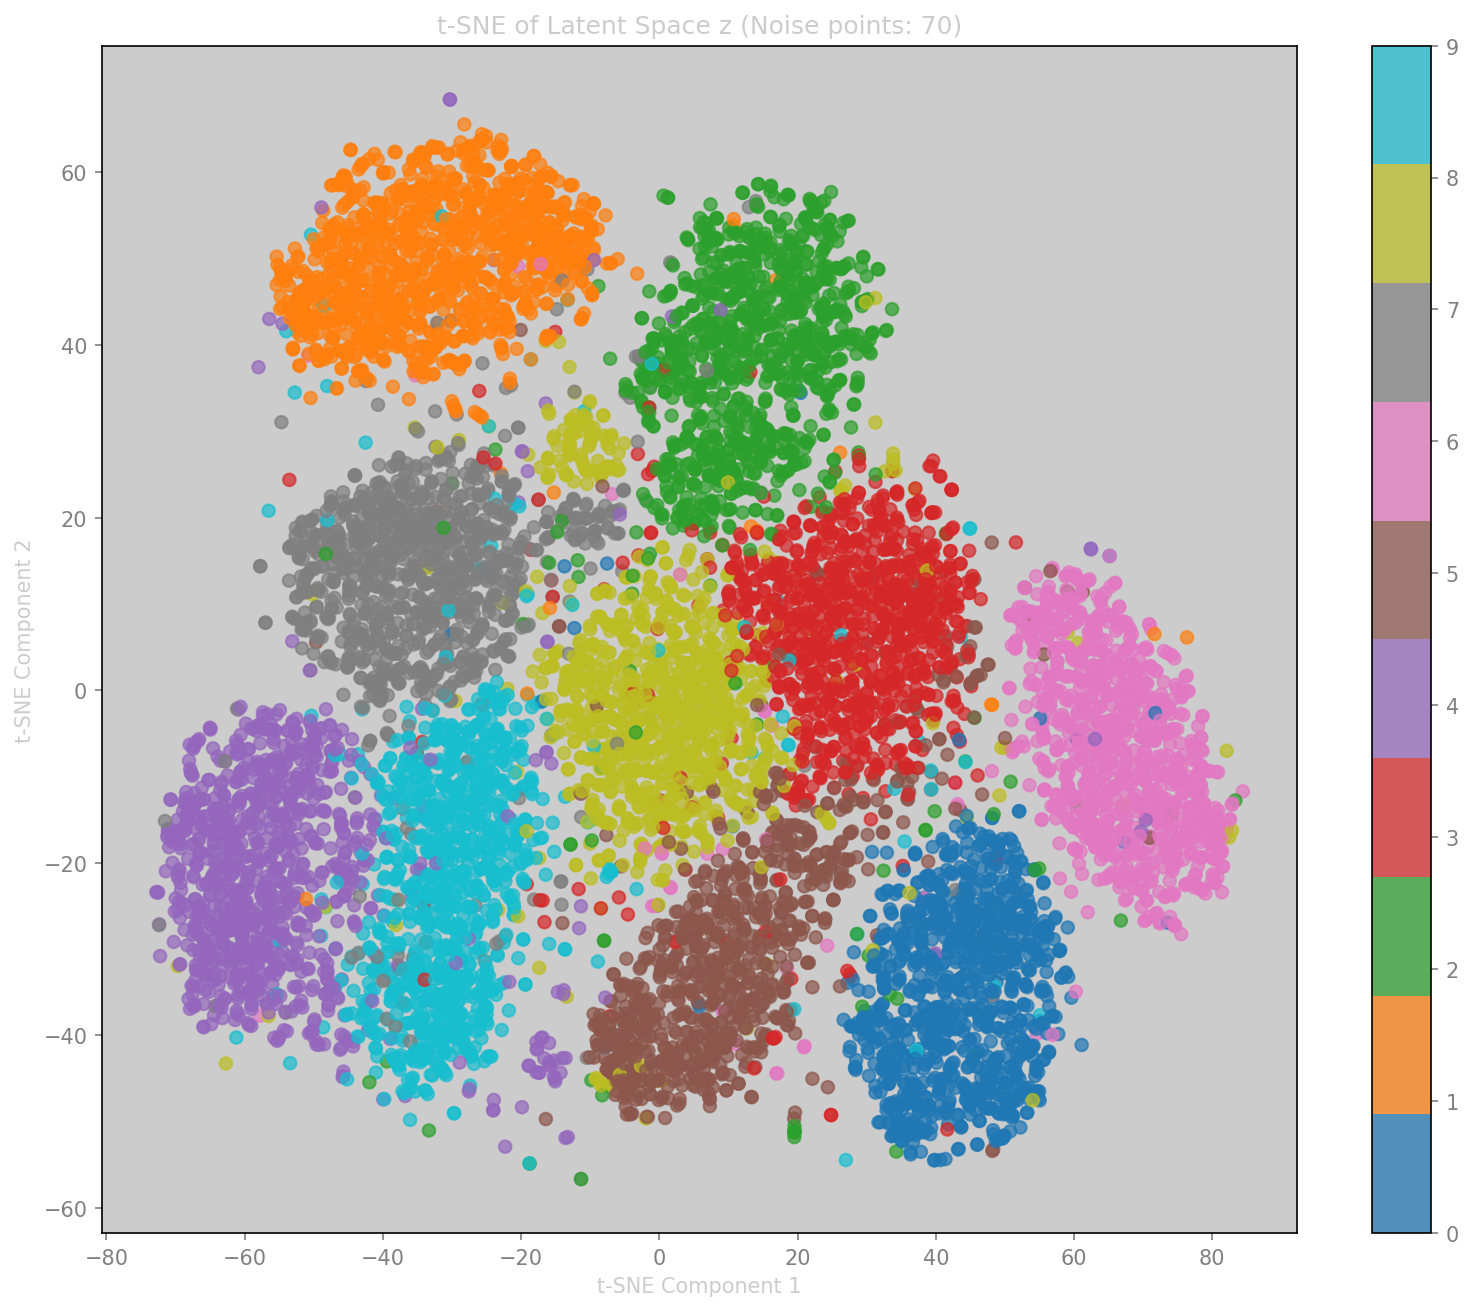

In [5]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN


def plot_laten_valuable(VAE, testloader):
    zs = []
    labels = []

    with torch.no_grad():
        for data, target in testloader:
            data = data.to(device)
            mu, logvar = VAE.encode(data)
            z = VAE.reparameterize(mu, logvar)
            zs.append(z.cpu())
            labels.append(target)

    # Concatenate all zs and labels
    zs = torch.cat(zs).numpy()
    labels = torch.cat(labels).numpy()

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    z_tsne = tsne.fit_transform(zs)
    # Apply DBSCAN to find clusters
    dbscan = DBSCAN(eps=3, min_samples=5)
    clusters = dbscan.fit_predict(z_tsne)

    # Count the number of labels not within the main groups (noise points)
    num_noise_points = (clusters == -1).sum()

    # Plot t-SNE results
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=labels, cmap="tab10", alpha=0.7)
    plt.colorbar(scatter, ticks=range(10))
    plt.title(f"t-SNE of Latent Space z (Noise points: {num_noise_points})")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()


plot_laten_valuable(VAE, testloader)

In [6]:
class ConvVAE_base(nn.Module):
    def __init__(self):
        super(ConvVAE_base, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc_mu = nn.Linear(128, 20)
        self.fc_logvar = nn.Linear(128, 20)

        # Decoder
        self.fc2 = nn.Linear(20, 128)
        self.fc3 = nn.Linear(128, 64 * 14 * 14)
        self.deconv1 = nn.ConvTranspose2d(
            64, 1, kernel_size=3, stride=2, padding=1, output_padding=1
        )

    def encode(self, x):
        h1 = F.relu(self.conv1(x))
        h1 = h1.view(-1, 64 * 14 * 14)
        h2 = F.relu(self.fc1(h1))
        return self.fc_mu(h2), self.fc_logvar(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc2(z))
        h4 = F.relu(self.fc3(h3))
        h4 = h4.view(-1, 64, 14, 14)
        return torch.sigmoid(self.deconv1(h4))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


def loss_function(recon_x, x, mu, logvar):

    BCE = F.mse_loss(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


# Check for MPS support
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example usage
print(f"Using device: {device}")

VAE_base = ConvVAE_base().to(device)

optimizer = torch.optim.Adam(VAE_base.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    VAE_base.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = VAE_base(data)
        loss = loss_function(recon_x, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(trainloader.dataset)} ({100. * batch_idx / len(trainloader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}"
            )

    print(
        f"====> Epoch: {epoch} Average loss: {train_loss / len(trainloader.dataset):.4f}"
    )

Using device: mps
Train Epoch: 0 [0/60000 (0%)]	Loss: 929.171509
Train Epoch: 0 [6400/60000 (11%)]	Loss: 523.630432
Train Epoch: 0 [12800/60000 (21%)]	Loss: 501.604309
Train Epoch: 0 [19200/60000 (32%)]	Loss: 459.183380
Train Epoch: 0 [25600/60000 (43%)]	Loss: 480.756042
Train Epoch: 0 [32000/60000 (53%)]	Loss: 489.056976
Train Epoch: 0 [38400/60000 (64%)]	Loss: 469.914276
Train Epoch: 0 [44800/60000 (75%)]	Loss: 478.324005
Train Epoch: 0 [51200/60000 (85%)]	Loss: 484.214844
Train Epoch: 0 [57600/60000 (96%)]	Loss: 445.282135
====> Epoch: 0 Average loss: 492.2629
Train Epoch: 1 [0/60000 (0%)]	Loss: 447.674072
Train Epoch: 1 [6400/60000 (11%)]	Loss: 468.173828
Train Epoch: 1 [12800/60000 (21%)]	Loss: 421.822540
Train Epoch: 1 [19200/60000 (32%)]	Loss: 472.395447
Train Epoch: 1 [25600/60000 (43%)]	Loss: 451.532715
Train Epoch: 1 [32000/60000 (53%)]	Loss: 443.176453
Train Epoch: 1 [38400/60000 (64%)]	Loss: 454.697723
Train Epoch: 1 [44800/60000 (75%)]	Loss: 434.908813
Train Epoch: 1 [5120

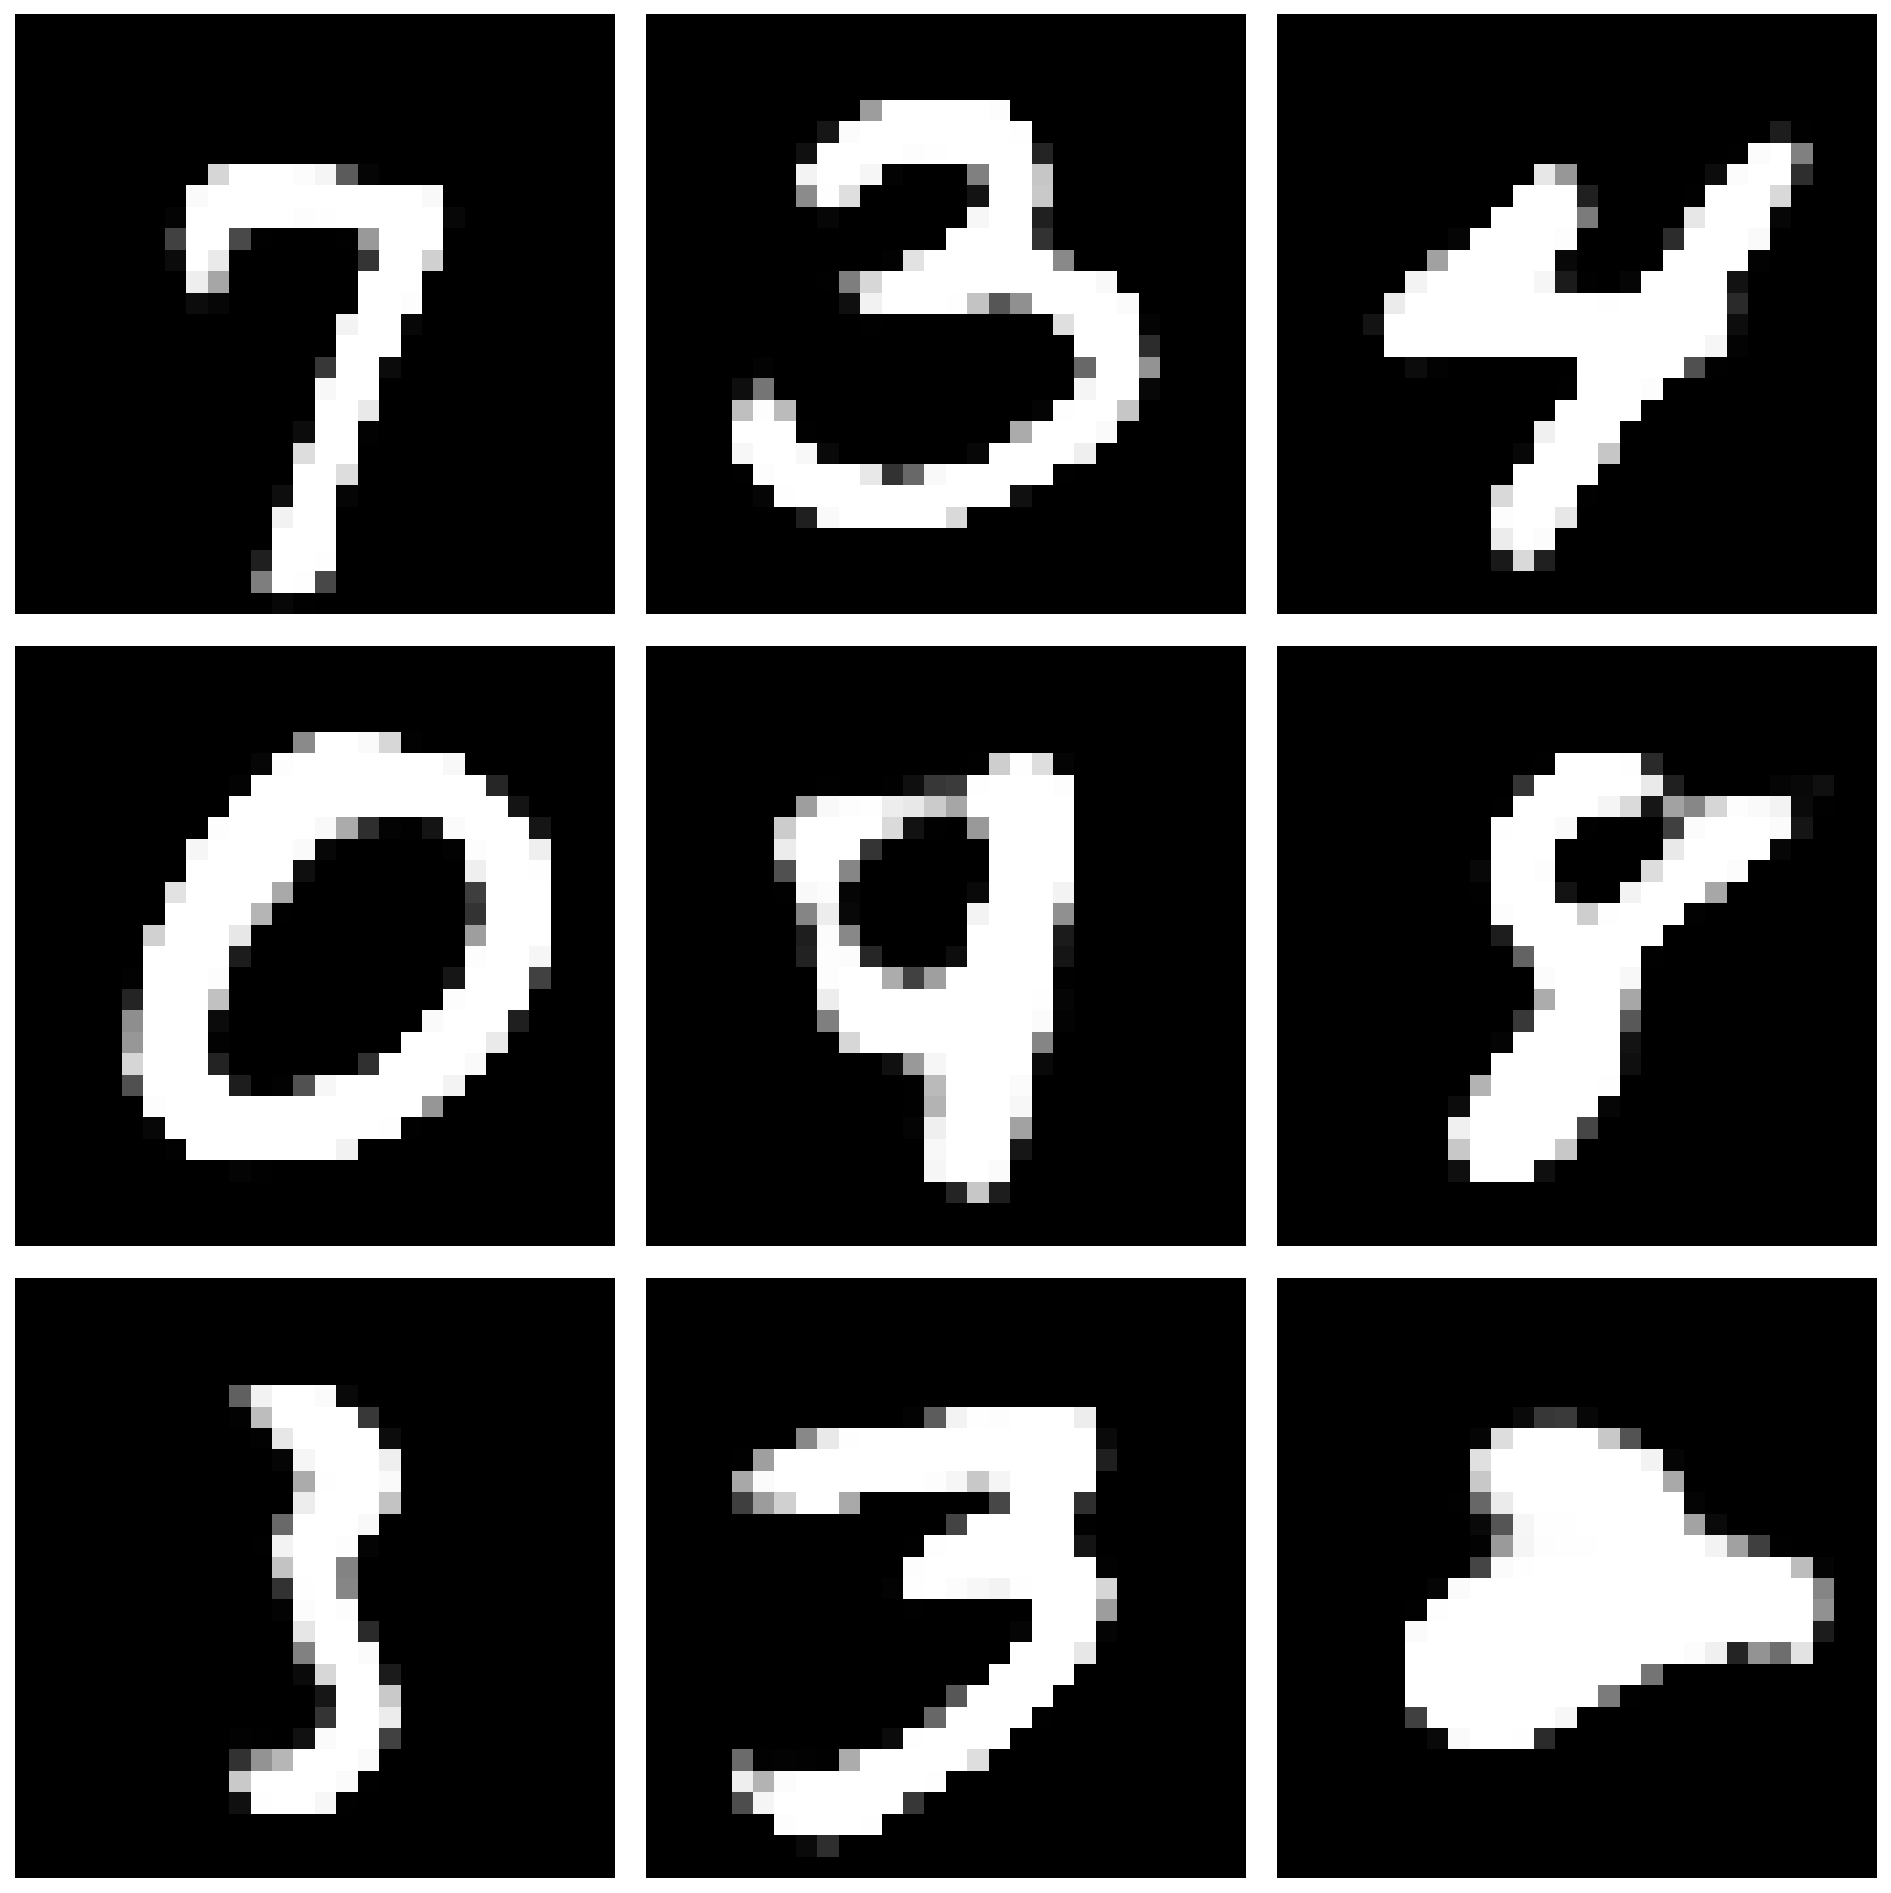

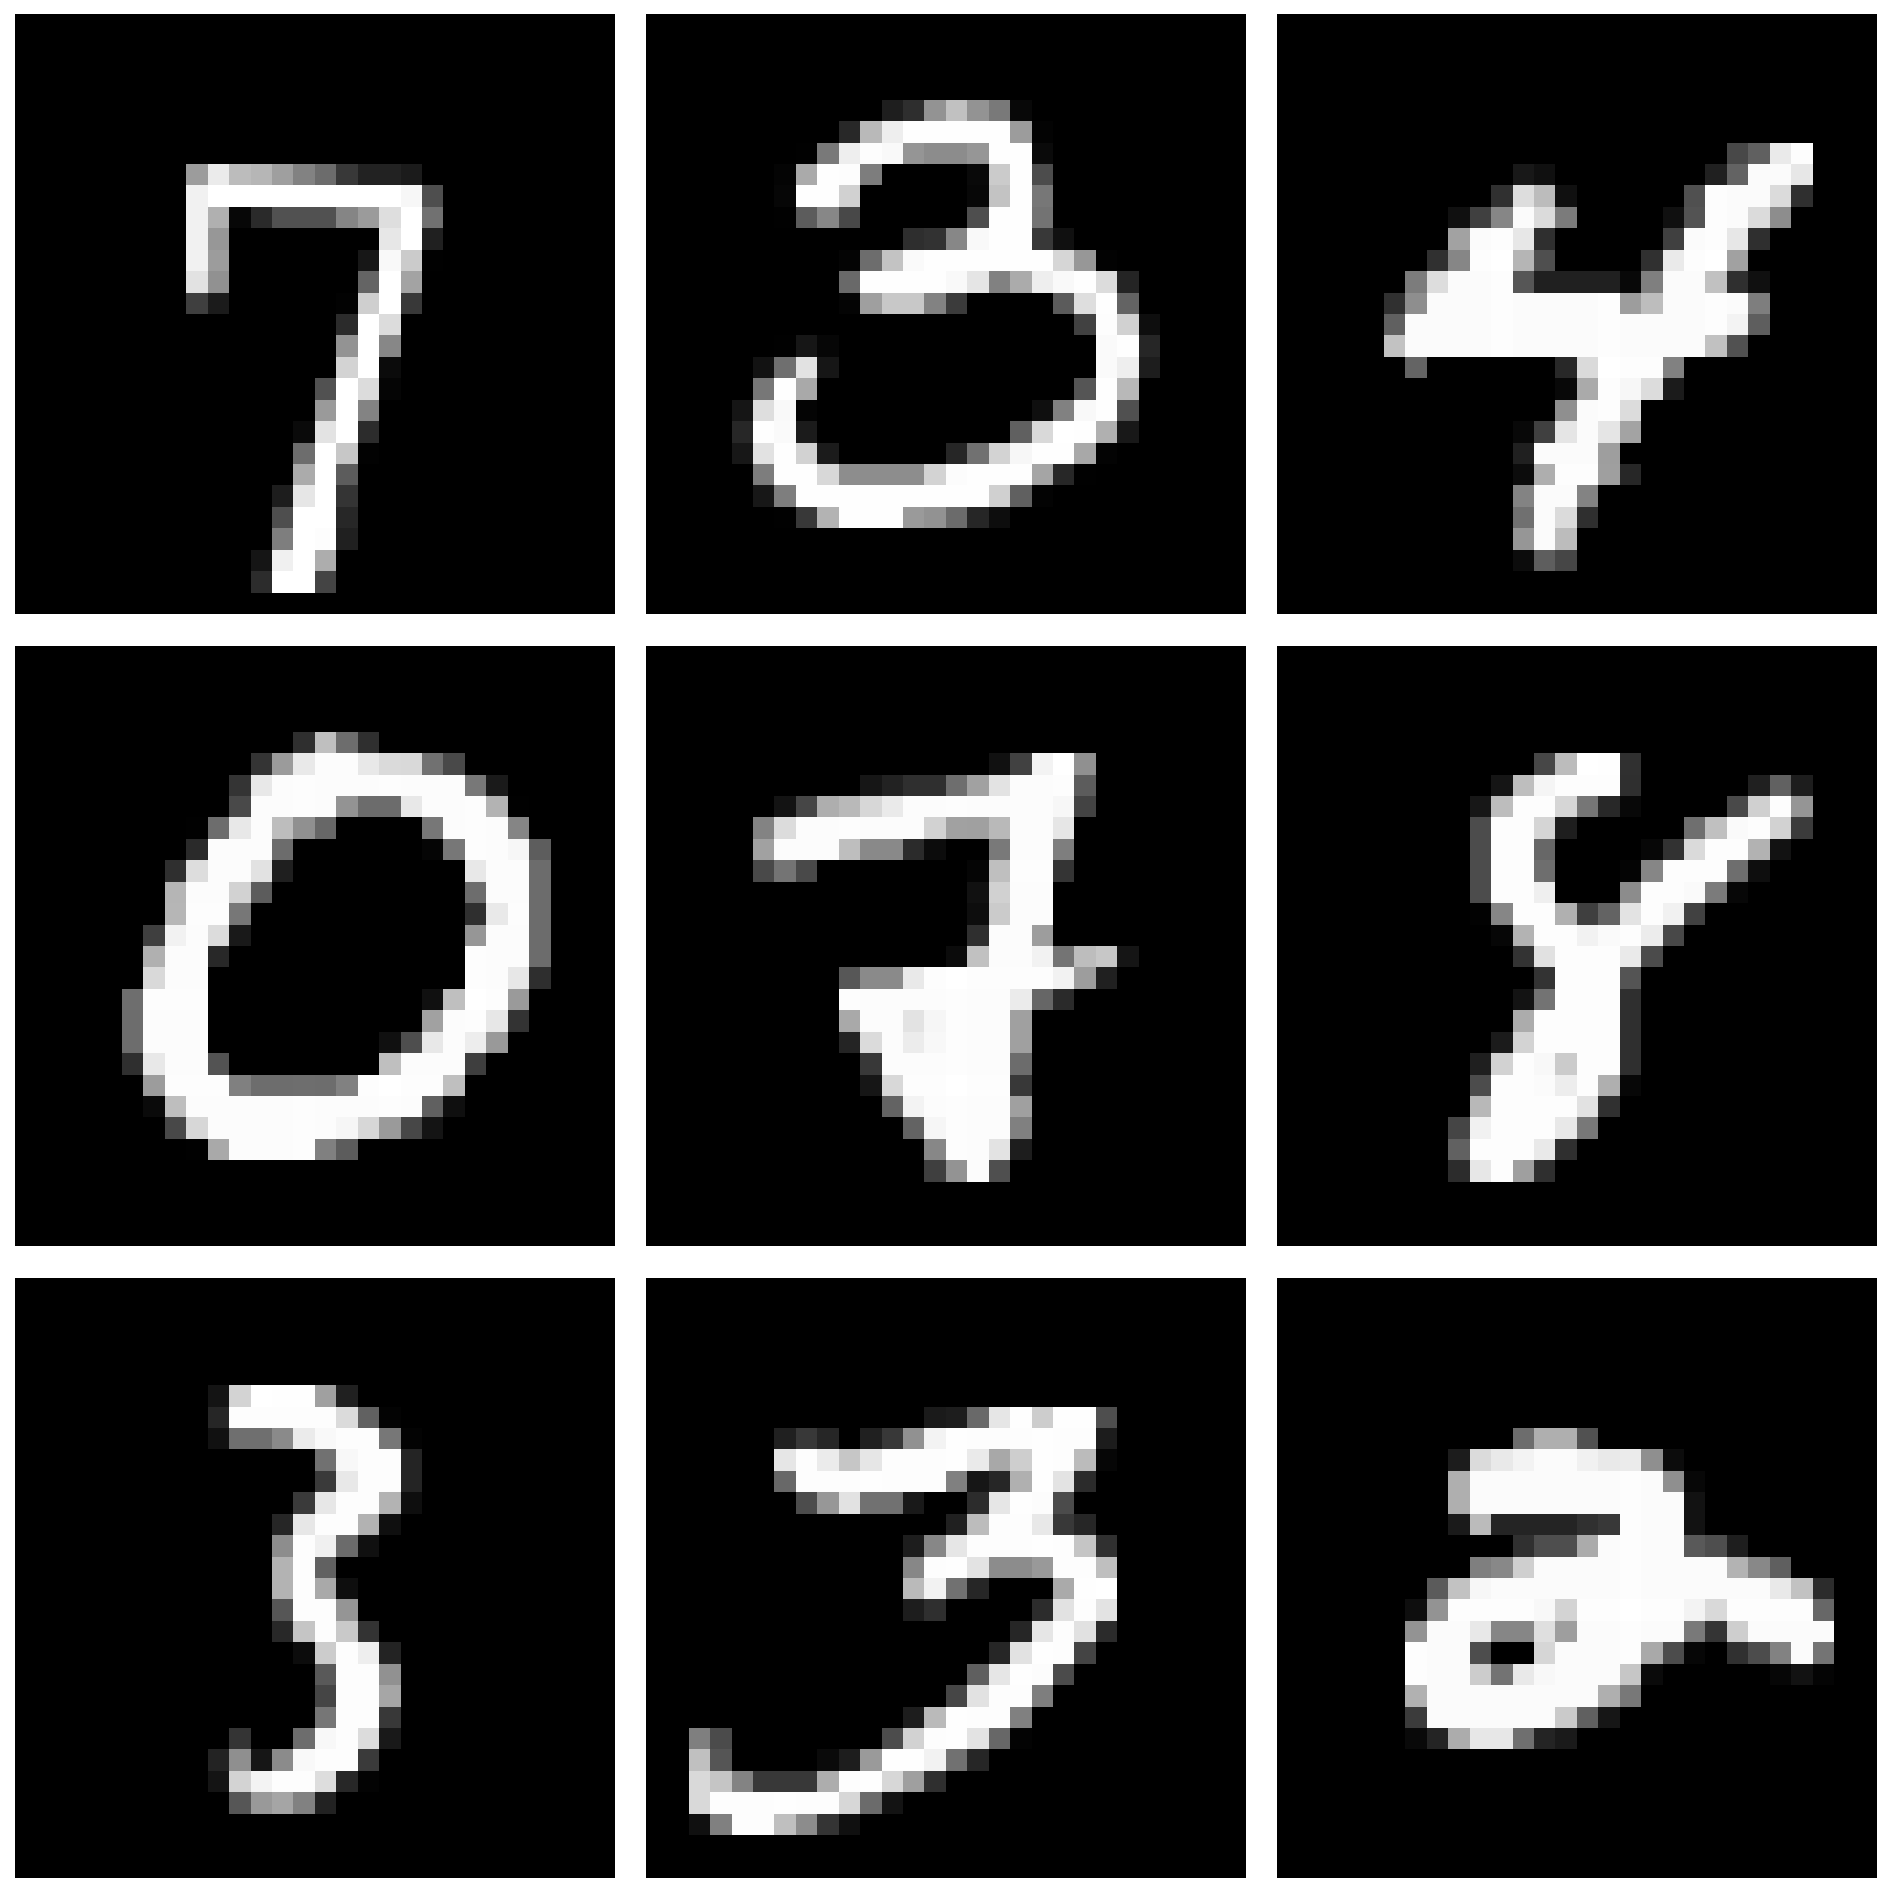

In [7]:
plot_reconstructions(recon_x.reshape(-1, 28, 28).cpu().detach().numpy())

plot_reconstructions(data.reshape(-1, 28, 28).cpu().detach().numpy())

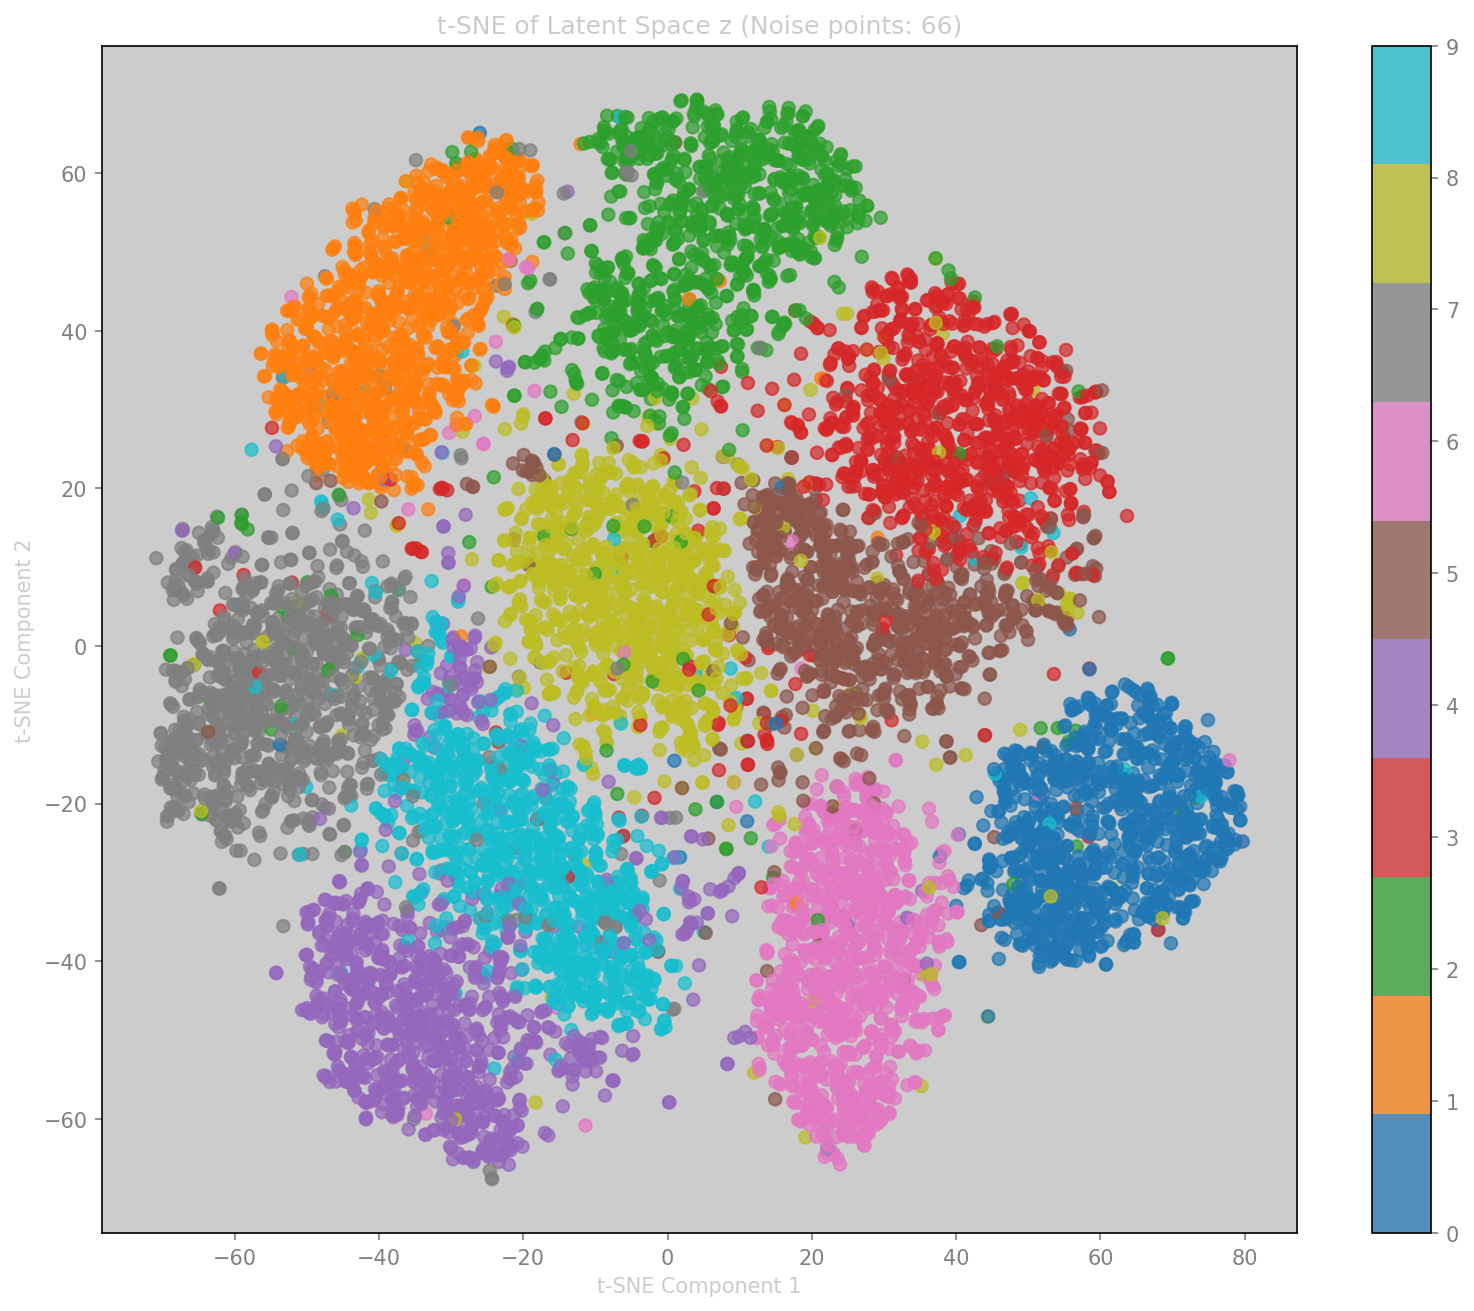

In [8]:
plot_laten_valuable(VAE_base, testloader)

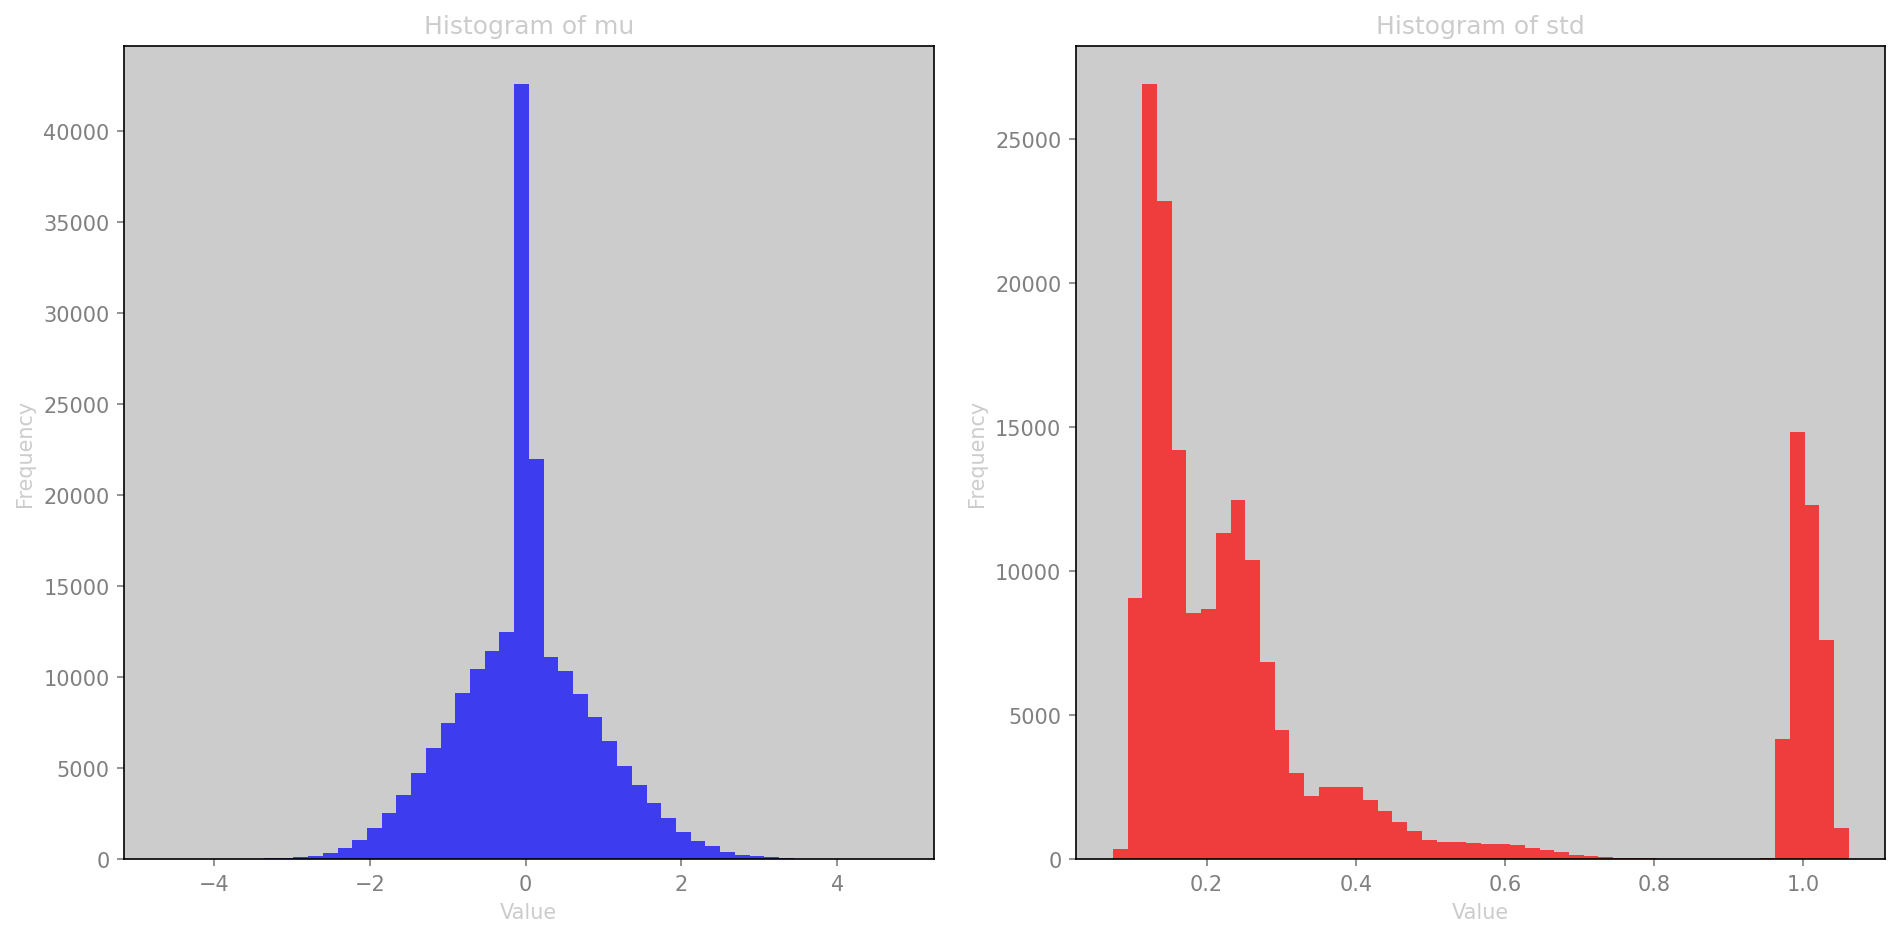

In [9]:
std = torch.exp(0.5 * logvar)


def plot_mu_std(VAE, testloader):
    # Collect all mu and std
    mus = []
    stds = []

    with torch.no_grad():
        for data, _ in testloader:
            data = data.to(device)
            mu, logvar = VAE.encode(data)
            std = torch.exp(0.5 * logvar)
            mus.append(mu.cpu())
            stds.append(std.cpu())

    # Concatenate all mus and stds
    mus = torch.cat(mus).numpy()
    stds = torch.cat(stds).numpy()

    # Plot mu
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(mus.flatten(), bins=50, color="blue", alpha=0.7)
    plt.title("Histogram of mu")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

    # Plot std
    plt.subplot(1, 2, 2)
    plt.hist(stds.flatten(), bins=50, color="red", alpha=0.7)
    plt.title("Histogram of std")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()


plot_mu_std(VAE_base, testloader)

In [ ]:
# Freeze all layers in the cnn model
for param in model.parameters():
    param.requires_grad = False